In [35]:
import requests as rq
import json as js
from pprint import pprint

In [36]:
URL = "https://api.bitfinex.com/v2" #base uri

symbol = "tTESTBTC:TESTUSD"

def candle_data(symbol, timeframe, **kwargs):
    curl = f'{URL}/candles/trade:{timeframe}:{symbol}/hist' #str timeframe in ['1m','5m','15m'...]
    params = {
        'limit' : 10000, #always max
        'sort' : 1 #old to new
    }
    if 'start' in kwargs:
        params['start'] = kwargs['start'] #str start in ms
    if 'end' in kwargs:
        params['end'] = kwargs['end'] #str end in ms
    raw = js.loads(rq.get(url=curl,params=params).text)
    return raw
candle_data(symbol,'5m',start='1605735618000')

[[1605736200000, 17770, 17763, 17770, 17763, 0.00044523],
 [1605736800000, 17779, 17779, 17779, 17779, 0.00023074],
 [1605737100000, 17734, 17734, 17734, 17734, 0.00022391],
 [1605737400000, 17732, 17732, 17732, 17732, 0.00020045],
 [1605737700000, 17740, 17740, 17740, 17740, 0.00025661],
 [1605738000000, 17744, 17744, 17744, 17744, 0.00021611],
 [1605738600000, 17713, 17713, 17713, 17713, 0.00020009],
 [1605738900000, 17805, 17805, 17805, 17805, 0.00022002],
 [1605739200000, 17811, 17811, 17811, 17811, 0.00023792],
 [1605739500000, 17845, 17845, 17846, 17845, 2],
 [1605740100000, 17832, 17832, 17832, 17832, 0.00020801],
 [1605740700000, 17781, 17781, 17781, 17781, 0.00022099],
 [1605741300000, 17799, 17799, 17799, 17799, 0.00022792],
 [1605741900000, 17749, 17749, 17749, 17749, 0.00021432],
 [1605742200000, 17754, 17754, 17754, 17754, 0.0002406],
 [1605742800000, 17803, 17803, 17803, 17803, 0.00023192],
 [1605743100000, 17832, 17832, 17832, 17832, 0.00021335],
 [1605743400000, 17738, 

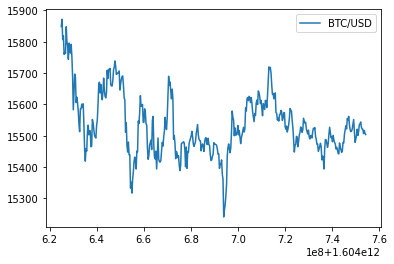

In [37]:
import matplotlib.pyplot as plt

#period = ['1604614500000','1605033900000'] # sideways
period = ['1604625000000','1604754485000'] # sideways
candles = candle_data(symbol, '5m', start=period[0], end=period[1])
ts = [cd[0] for cd in candles]
candles = [cd[1] for cd in candles]
plt.plot(ts, candles, label='BTC/USD')
plt.legend()
plt.show()

# Run backtest
Assuming a simple ladder of orders with spread = 2 bpu and density = 1 bpu, quantity constant in quote: 1.5k USD.
Requirement format: spread = 2 bpu, density += 10 bpu = 13.5k USD

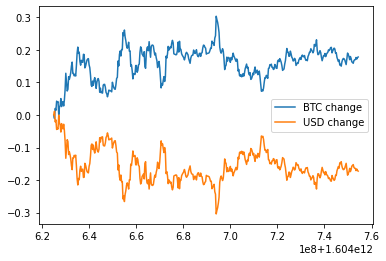

BTC Change: 0.17820633214008225
USD Change: -0.1725


In [38]:
btc_initial = 200
usd_initial = 3000000
quantity = 1500 # determined according to requirements and risk tolerance

btc = btc_initial
usd = usd_initial
btc_change = [0]
usd_change = [0]

for i in range(1, len(candles)):
    if candles[i]-candles[i-1] > 0:
        levels = candles[i]-candles[i-1]
        btc -= sum([quantity/(candles[i]+j) for j in range(levels)])
        usd += levels*(quantity)
    else:
        levels = candles[i-1]-candles[i]
        btc += sum([quantity/(candles[i]-j) for j in range(levels)])
        usd -= levels*(quantity)
    btc_change.append((btc-btc_initial)/btc_initial)
    usd_change.append((usd-usd_initial)/usd_initial)

plt.plot(ts, btc_change, label='BTC change')
plt.plot(ts, usd_change, label='USD change')
plt.legend()
plt.show()

print(f'BTC Change: {btc_change[-1]}')
print(f'USD Change: {usd_change[-1]}')

# Risk hedging
If gain of one asset (e.g.) is considered adverse event: make use of derivatives (perpetuals) to open and adjust risk hedging position.

# REST API client

In [39]:
import requests
import json
import hmac
import hashlib
import time

class ClientREST:
    
    PUBLIC_URL = 'https://api-pub.bitfinex.com'
    AUTHENTICATED_URL = 'https://api.bitfinex.com'
    
    def __init__(self, **kwargs):
        self.publickey = kwargs.get('publickey')
        self.secretkey = kwargs.get('secretkey')
        
    def orderbook(self, symbol):
        response = requests.get(f'{self.PUBLIC_URL}/v2/book/{symbol}/P0')
        return json.loads(response.text)
    
    def auth_headers(self, path, **kwargs):
        nonce = int(time.time()*1000)
        msg = f'/api{path}{nonce}{json.dumps(kwargs)}'
        signature = hmac.new(self.secretkey.encode(), msg.encode(),haslib.sha384).hexdigest()
        return {
            'Content-Type' : 'application/json',
            'bfx-nonce' : str(nonce),
            'bfx-apikey' : self.publickey,
            'bfx-signature' : signature
        }
    
    def placeorder(self, **kwargs):
        path = '/v2/auth/w/order/submit'
        headers = self.auth_headers(path, **kwargs)
        response = requests.post(f'{self.AUTHENTICATED_URL}{path}',data=json.dumps(kwargs),headers=headers)
        return json.loads(response.text)
    
    def getorders(self):
        path = '/v2/auth/r/orders'
        headers = self.auth_headers(path)
        response = requests.post(f'{self.AUTHENTICATED_URL}{path}',data=json.dumps({}),headers=headers)
        return json.loads(response.text)

# Websocket client

In [46]:
from websocket import create_connection
from threading import Thread

class ClientWS:
    
    PUBLIC_URL = 'wss://api-pub.bitfinex.com/ws/2'
    AUTHENTICATED_URL = 'wss://api.bitfinex.com/ws/2'
    
    def __init__(self, **kwargs):
        self.publickey = kwargs.get('publickey')
        self.secretkey = kwargs.get('secretkey')
        self.public = create_connection(self.PUBLIC_URL)
        self.auth = create_connection(self.AUTHENTICATED_URL)
        self.authenticate()
        self.rest = ClientREST(**kwargs)
        
    def authenticate(self):
        nonce = int(time.time()*1000)
        msg = f'AUTH{nonce}'
        signature = hmac.new(self.secretkey.encode(), msg.encode(),hashlib.sha384).hexdigest()
        payload = {
            'apiKey' : self.publickey,
            'authSig' : signature,
            'authNonce' : str(nonce),
            'authPayload' : msg,
            'event' : 'auth'
        }
        self.auth.send(json.dumps(payload))
    
    def subscribe(self, channel, **kwargs):
        payload = {
            'event' : 'subscribe',
            'channel' : channel,
            **kwargs
        }
        self.public.send(json.dumps(payload))
        
    def listen_public(self, handler):
        while True:
            msg = self.public.recv()
            handler(json.loads(msg))
    
    def listen_auth(self, handler):
        while True:
            msg = self.auth.recv()
            handler(json.loads(msg))
    
    def listen(self, handler):
        public_thread = Thread(target=self.listen_public,args=[handler])
        auth_thread = Thread(target=self.listen_auth,args=[handler])
        public_thread.start()
        auth_thread.start()

# Execution of simple PDMM, exercise
1. Place a bid order at 1 tick above bid 1 if the sum of the first 3 bids is more htan twice the sum of the first 3 asks
2. If the bid order is filled, place an ask order at 1 bpu higher than the bid order
3. Repeat step 1 if the ask order is filled

# Execution code with REST client
Use a while loop as execution loop in chronicle order
1. Request data from server
2. Execute orders base on the response
3. Repeat

In [47]:
MYPUBLICKEY = '3EUaZ88DNEwJ5xqhopP4djATyONhOzDuudB5fVjjIKh'
MYSECRETKEY = 'bOyRJQN345MX8r8ZuuBjdrTJCVgJPIpnsHRFxFKU'

# Create the client object
client = ClientREST(publickey = MYPUBLICKEY, secretkey = MYSECRETKEY)

# Define global constants
DECIMAL = 4
AMOUNT = 1
MARGIN = 1
SYMBOL = 'tTESTBTC:TESTUSD'
SLEEP = 3

# Define global variables
GLOBAL = {
    'step' : 0
}

#Requst orderbook data, check if condition is met, place order if condition is met
def step0():
    book = client.orderbook(SYMBOL)
    asks = sorted([order for order in book if order[2] < 0], key=lambda order: order[0])
    bids = sorted([order for order in book if order[2] > 0], key=lambda order: order[0], reverse=True)
    if len(asks) >= 3 and len(bids) >= 3:
        sumAsks = sum([-asks[i][2] for i in range(3)])
        sumBids = sum([bids[i][2] for i in range(2)])
        print(f'{time.asctime()}: Ask {sumAsks} Bid {sumBids}')
        if sumBids >= sumAsks*2:
            price = bids[0][0]+1
            response = client.placeorder(type='EXCHANGE LIMIT', symbol=SYMBOL,price=str(round(price)),amount=str(AMOUNT))
            print(f'{time.asctime()}: {response}')
            GLOBAL['step'] = 1
            GLOBAL['price'] = price
            
# Check if bid order is filled, if filled, place ask order accordingly
def step1():
    orders = client.getorders()
    print(f'{time.asctime()}: {orders}')
    if orders == []:
        response = client.placeorder(type='EXCHANGE LIMIT', symbol=SYMBOL, price=str(round(GLOBAL['price']+MARGIN)), amount=str(-AMOUNT))
        print(f'{time.asctime()}: {response}')
        GLOBAL['step'] = 2

def step2():
    orders = client.getorders()
    print(f'{time.asctime()}: {orders}')
    if orders == []:
        GLOBAL['step'] = 0

#Start execution loop
while True:
    if GLOBAL['step'] == 0:
        step0()
    elif GLOBAL['step'] == 1:
        step1()
    elif GLOBAL['step'] == 2:
        step2()
    time.sleep(SLEEP)

Thu Jun  3 20:02:45 2021: Ask 5.70995613 Bid 2.93209975
Thu Jun  3 20:02:48 2021: Ask 5.70929991 Bid 2.9319170999999997


KeyboardInterrupt: 

In [48]:
MYPUBLICKEY = '3EUaZ88DNEwJ5xqhopP4djATyONhOzDuudB5fVjjIKh'
MYSECRETKEY = 'bOyRJQN345MX8r8ZuuBjdrTJCVgJPIpnsHRFxFKU'

# Establish connection and subscribe to channels
ws = ClientWS(publickey=MYPUBLICKEY,secretkey=MYSECRETKEY)
ws.subscribe('book',symbol=SYMBOL)

# Define global constants
DECIMAL = 4
MARGIN = 1
SYMBOL = 'tTESTBTC:TESTUSD'

# Define global variables
GLOBAL = {
    'asks' : {},
    'bids' : {},
    'amount' : 1
}

#Build event handlers
def on_subscribed(msg):
    if type(msg) == dict and msg.get('event') == 'subscribed' and msg.get('channel') == 'book':
        GLOBAL['orderbookChannelId'] = msg['chanId']

def on_orderbook(msg):
    if type(msg) == list and msg[0] == GLOBAL.get('orderbookChannelId'):
        if type(msg[1][0]) == list:
            for order in msg[1]:
                price = order[0]
                count = order[1]
                amount = order[2]
                if amount > 0:
                    GLOBAL['bids'][price] = amount
                elif amount < 0:
                    GLOBAL['asks'][price] = -amount
                    
        else:
            price = msg[1][0]
            count = msg[1][1]
            amount = msg[1][2]
            if count == 0 and amount == 1:
                del GLOBAL['bids'][price]
            elif count == 0 and amount == -1:
                del GLOBAL['asks'][price]
            elif amount > 0:
                GLOBAL['bids'][price] = amount
            elif amount < 0:
                GLOBAL['asks'][price] = -amount
        if GLOBAL['amount'] > 0.001 and len(GLOBAL['asks']) >= 3 and len(GLOBAL['bids']) >= 3:
            sortedAsks = sorted(GLOBAL['asks'])
            sortedBids = sorted(GLOBAL['bids'])
            sumAsks = sum(GLOBAL['asks'][sortedAsks[i]] for i in range(3))
            sumBids = sum(GLOBAL['bids'][sortedBids[i]] for i in range(3))
            print(f'{time.asctime()}: Ask {sumAsks} Bid {sumBids}')
            if sumBids >= sumAsks*2:
                response = ws.rest.placeorder(type='EXCHANGE LIMIT', symbol=SYMBOL,price=str(round(price*1.01)),amount=str(round(-amount,DECIMAL)))
                print(f'{time.asctime()}: {response}')
                GLOBAL['amount'] = 0
                
def on_fill(msg):
    if type(msg) == list and msg[0] == 0 and msg[1] == 'ts':
        amount = msg[2][4]
        price = msg[2][5]
        if amount > 0:
            response = ws.rest.placeorder(type='EXCHANGE LIMIT', symbol=SYMBOL,price=str(round(price*1.01)),amount=str(round(-amount,DECIMAL)))
            print(f'{time.asctime()}: {response}')
        else:
            GLOBAL['amount'] += -amount
            
def handler(msg):
    on_subscribed(msg)
    on_orderbook(msg)
    on_fill(msg)

# Start listening to messages
ws.listen(handler)

Thu Jun  3 20:02:52 2021: Ask 5.70787833 Bid 0.08052350999999999
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.08052350999999999
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.08052350999999999
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.08052350999999999
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:54 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:55 2021: Ask 5.70787833 Bid 0.12
Thu Jun  3 20:02:55 2021: Ask 8.33025831 Bid 0.12
Thu Jun  3 20:02:55 2021: Ask 8.33025831 Bid 0.12
Thu Jun  3 20:02:55 2021: Ask 5.708197569999999 Bid 0.12
Thu Jun  3 20:02:57 2021: Ask 5.7

# Exercise suggestion
Refine the execution code using all or a combination of the following:
- add functions to the client to adjust orders as much as needed
- add an indicator (price data) to detect short-term price tendencies
- use orderbook dynamics to detect short-term price tendencies
- optimize order placement conditions